# Traductor Español-Inglés Machine translation
### Ignacio Díaz-Guardamino

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
print(tf.__version__)

1.13.2


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [5]:
data = read_text("spa.txt")
es_eng = to_lines(data)
es_eng = array(es_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [6]:
es_eng = es_eng[:50000,0:2]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
es_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [8]:
# Remove punctuation
es_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in es_eng[:,0]]
es_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)).replace('¿', '') for s in es_eng[:,1]]

In [9]:
es_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

In [10]:
# convert to lowercase
for i in range(len(es_eng)):
    es_eng[i,0] = es_eng[i,0].lower()
    
    es_eng[i,1] = es_eng[i,1].lower()

In [11]:
es_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [12]:
# empty lists
eng_l = []
es_l = []

# populate the lists with sentence lengths
for i in es_eng[:,0]:
    eng_l.append(len(i.split()))

for i in es_eng[:,1]:
    es_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'es':es_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.es))

       eng  es
0        1   1
1        1   1
2        1   1
3        1   1
4        1   1
...    ...  ..
49995    6   5
49996    8   6
49997    6   5
49998    5   4
49999    4   3

[50000 rows x 2 columns]
8
12


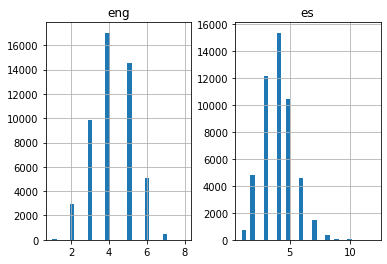

In [14]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(es_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [17]:
# prepare Deutch tokenizer
es_tokenizer = tokenization(es_eng[:, 1])
es_vocab_size = len(es_tokenizer.word_index) + 1

es_length = 8
print('Spanish Vocabulary Size: %d' % es_vocab_size)

Spanish Vocabulary Size: 13809


In [18]:
#print(es_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(es_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(es_tokenizer, es_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1516 ...    0    0    0]
 [4710    4    6 ...    0    0    0]
 [  14 4834    0 ...    0    0    0]
 ...
 [  41  189 1606 ...    0    0    0]
 [  21   12   15 ...    8 1148    0]
 [   2  233 1420 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [22]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [23]:
# prepare validation data
testX = encode_sequences(es_tokenizer, es_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   41   30 ...    0    0    0]
 [ 220    4    1 ...    0    0    0]
 [  72 8386    0 ...    0    0    0]
 ...
 [9350  115  934 ...    0    0    0]
 [ 536   56  574 ...    0    0    0]
 [   2   33 6577 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [24]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [25]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [26]:
print(es_vocab_size)
print(eng_vocab_size)
print(es_length)
print(eng_length)

13809
6942
8
8


In [27]:
model = build_model(es_vocab_size, eng_vocab_size, es_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [28]:
filename = 'model.h2.5-5-20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)
#modelo h1:  0.5847 - val_loss: 1.7952
#modelo h2:  loss: 0.1071 - val_loss: 2.8036

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - 460s 7ms/step - loss: 4.6371 - val_loss: 4.3218

Epoch 00001: val_loss improved from inf to 4.32182, saving model to model.h2.5-5-20
Epoch 2/50
64000/64000 [==============================] - 477s 7ms/step - loss: 4.1416 - val_loss: 4.0307

Epoch 00002: val_loss improved from 4.32182 to 4.03071, saving model to model.h2.5-5-20
Epoch 3/50
64000/64000 [==============================] - 464s 7ms/step - loss: 3.9145 - val_loss: 3.8874

Epoch 00003: val_loss improved from 4.03071 to 3.88743, saving model to model.h2.5-5-20
Epoch 4/50
64000/64000 [==============================] - 467s 7ms/step - loss: 3.6800 - val_loss: 3.6338

Epoch 00004: val_loss improved from 3.88743 to 3.63378, saving model to model.h2.5-5-20
Epoch 5/50
64000/64000 [========================

Let's compare the training loss and the validation loss.

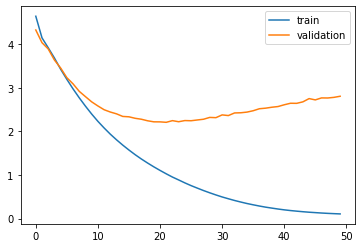

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [28]:
model = load_model('model.h1.4-5-20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [31]:
pred_df = pd.DataFrame({'ES' : test[:,1], 'actual' : test[:,0], 'predicted' : preds_text})

In [32]:
pd.set_option('display.max_colwidth', 200)

In [33]:
pred_df.head(15)

,ES,actual,predicted
0,ellos son muy optimistas,they are very cheerful,please about for you
1,conozco a tom,i know tom,help tom
2,puedes negarte,you may refuse,just look a
3,eso es privado,thats private,its is
4,tom saltó desde su asiento,tom leaped from his seat,tom should me to you
5,jamás has vendido un auto,have you ever sold a car,ten old will as
6,cuántos hijos tienes,how many kids do you have,well to you
7,no te dejaré hacerlo,i will not let you do it,dont it again
8,no es hermoso,isnt it beautiful,its not natural
9,mi loro murió ayer,my parrot died yesterday,they gave to a to


In [34]:
pred_df.tail(15)

,ES,actual,predicted
9985,tom y mary saben,do tom and mary know,where i be
9986,tom puede ser burdo,tom can be clumsy,tom thinks lying
9987,querés probarlo,do you want to try it,i hate my
9988,sabes quién era,do you know who he was,tom was at
9989,también es una belleza,shes also a beauty,your is dirty
9990,quiero a su hija,i love your daughter,i want something change
9991,él da clases de inglés,he teaches english,she is having for
9992,me quedé dormido,i overslept,he gave me a job
9993,él es pobre como pocos,he is as poor as can be,he is the tv
9994,dónde está mi camisa,wheres my shirt,this is tonight


In [35]:
pred_df.sample(15)

,ES,actual,predicted
7436,no soy la hermana de tom,im not toms sister,im not your tom
3798,no debes salir hoy,you must not go out today,dont take your choice
6781,eres realmente hermosa,you sure are pretty,i know how eat
5776,prueba esta salsa,try this sauce,that
7819,tom se movió,tom moved,tom became a
9864,ella se vestía como un niño,she dressed like a boy,im am of this
5702,tengo que ir al banco,i have to go to the bank,tom thinks mary
6264,ahora estoy jugando al fútbol,im playing football now,tom was in work
865,ella no vino a fin de cuentas,she didnt come after all,im not a at a
9958,tomás todavía hace vida de soltero,tom is still a bachelor,i can win this


In [36]:
frases=["él estaba muy borracho","tienes razón","ve a casa",]
fe=encode_sequences(es_tokenizer, es_length, frases)
print(fe)
print("===========")
pr=model.predict_classes(fe)
print(pr)
for i in pr:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)           
        
    print(' '.join(temp))

[[ 11  42  30 505   0   0   0   0]
 [ 68 213   0   0   0   0   0   0]
 [188   4  51   0   0   0   0   0]]
3
[[ 11  42  30 505   0   0   0   0]
 [ 68 213   0   0   0   0   0   0]
 [188   4  51   0   0   0   0   0]]
[[   8   15   38   38    0    0    0    0]
 [  44    5  220    0    0    0    0    0]
 [ 636   21 2586    0    0    0    0    0]]
he was here     
youre a mine     
save your dice     


In [ ]:
## observaciones:
'''se han probado dos modelos, el primero, model.h1.4-5-20, mas simple, entrenado con menos palabras y con poco overfitting, que funciona razonablemente bien, es el que se muestra en los resultados anteriores.

el segundo, model.h2.5-5-20, se ha entrenado con el doble de palabras y 50 epochs, según el grafico tiene bastante overfitting. Pero cuando observamos los resultados, se puede ver que aunque en muchas situaciones las respuestas no coincida, no se puede decir que sean incorrectas:


    español                     Inglés                          Predicción
podéis usar ese teléfono	you can use that phone         	you can use this phone
son los mejores	            you are the best            	are the best
tengo que abrir la ventana	do i have to open the window	i need to open the window
'''